## Biquad/Z-Transform... 

In progress... a few placeholders are here... 



In [12]:
# Import the necessary packages as usual
%pip install ipympl
import numpy as np 
import scipy as sp
from scipy import signal
from  matplotlib import patches
from matplotlib.ticker import FormatStrFormatter
import io
from scipy.io import wavfile
from pyodide.http import pyfetch
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib ipympl

# function for reading WAV files from a URL. Must be a RAW link, not GitHub HTML
speech_sample = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/F2.wav"
impulse_resp = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/IR1.wav"

async def read_wav_from_url(url):
    response = await pyfetch(url)
    wav_bytes = await response.bytes()  # get raw binary
    fs, data = wavfile.read(io.BytesIO(wav_bytes))

    # convert to float in [-1, 1]
    if np.issubdtype(data.dtype, np.integer):
        max_val = np.iinfo(data.dtype).max
        data = data.astype(np.float32) / max_val
    else:
        data = data.astype(np.float32)  # already float
    
    return data, fs

Note: you may need to restart the kernel to use updated packages.


### A single parameter adaptive notch filter


#### The constrained biquad filter


Let us first recall the biquad filter in the $z$-domain without any constraints:

\begin{equation}
H(z^{-1}) = \frac{b_{o} + b_{1} z^{-1} + b_{2}z^{-2} }{1 + a_{1} z^{-1} + a_{2}z^{-2} }.
\end{equation}  

With $b_{o} = 1$, the biquad can be expressed in polar coordinates (in the complex plane) in terms of a zero radius, $\zeta$, and zero angle $\omega_{z}$, and a pole radius, $\rho$, and pole angle, $\omega_{p}$ as follows

$\begin{equation}
H(z^{-1}) = \frac{(1 - \zeta e^{j\omega_{z}}  z^{-1}) (1 - \zeta e^{-j\omega_{z}} z^{-1})  }{(1 - \rho e^{j\omega_{p}} z^{-1}) (1 - \rho e^{-j\omega_{p}} z^{-1})}
\end{equation}$  
where $b_{1}  = -(\zeta e^{j\omega_{z}} + \zeta e^{-j\omega_{z}}) = -2 \zeta \cos(\omega_{z})$,  $b_{2} = \zeta^{2}$, $a_{1}  =   -2 \rho \cos(\omega_{p})$,  and $a_{2} = \rho^{2}$. There are 4 parameters here that can be adjusted to configure the biquad in various ways. 





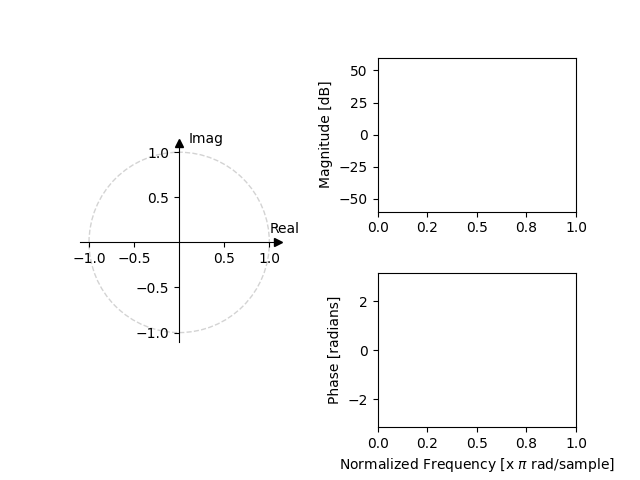

Move the slider to see how the filter changes with the positions of the poles and zeros!
Note that the omega parameter is the true value of omega in radians, but the x-axis of the Magnitude/Phase plots are normalized by $\pi$


interactive(children=(FloatSlider(value=0.8, description='rho', max=0.999, step=0.001), FloatSlider(value=0.95…

In [11]:
# Setting up the plots
fig, axes = plt.subplot_mosaic([["top left", "top centre"],["top left", "bottom centre"]])
plt.subplots_adjust(wspace=0.5,hspace=0.4)

# Create the unit circle
uc = patches.Circle((0,0), radius=1, fill=False, color='lightgray', ls='dashed')
axes["top left"].add_patch(uc)
 

# Plot the zeros and set marker properties    
t1, = axes["top left"].plot([], [], 'ko', ms=10)
plt.setp( t1, markersize=8.0, markeredgewidth=1.0,
          markeredgecolor='k', markerfacecolor='k')

# Plot the poles and set marker properties
t2, = axes["top left"].plot([], [], 'kx', ms=10)
plt.setp( t2, markersize=8.0, markeredgewidth=3.0,
          markeredgecolor='k', markerfacecolor='r')

axes["top left"].spines['left'].set_position('center')
axes["top left"].spines['bottom'].set_position('center')
axes["top left"].spines['right'].set_visible(False)
axes["top left"].spines['top'].set_visible(False)

axes["top left"].plot(1, 0, ">k", transform=axes["top left"].get_yaxis_transform(), clip_on=False)
axes["top left"].plot(0, 1, "^k", transform=axes["top left"].get_xaxis_transform(), clip_on=False)

# set the ticks
r = 1.1; 
axes["top left"].axis('scaled');
ticks_x = [-1, -0.5, 0.5, 1]; 
ticks_y = [-1, -0.5, 0.5, 1]; 
axes["top left"].set_xticks(ticks_x)
axes["top left"].set_yticks(ticks_y)
axes["top left"].text(1,0.1,'Real');
axes["top left"].text(0.1,1.1,'Imag');



lineMag, = axes["top centre"].plot([], [], 'k')
axes["top centre"].set_ylabel('Magnitude [dB]', color='k')
axes["top centre"].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes["top centre"].set_xlim([0, 1])
axes["top centre"].set_ylim([-60, 60])


# angles = np.unwrap(np.angle(h))
linePh, = axes["bottom centre"].plot([], [], 'k')
axes["bottom centre"].set_ylabel('Phase [radians]', color='k')
axes["bottom centre"].set_xlabel('Normalized Frequency [x $\pi$ rad/sample]')
axes["bottom centre"].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes["bottom centre"].set_ylim([-np.pi, np.pi])
axes["bottom centre"].set_xlim([0, 1])
# axes["bottom centre"].axis('tight')
plt.show()

# Create the interactive plot
def update(rho = 0.8, zeta = 0.95, omegaz=np.pi/4, omegap = np.pi/4):
    

    bo = 1;
    b1 = -2*np.cos(omegaz)*zeta;
    b2 = zeta**2;

    a1 = -2*np.cos(omegap)*rho;
    a2 = rho**2;

    b = [bo,b1,b2];
    a = [1,a1,a2];

    # FREQZ to get magnitude and phase
    w, h = signal.freqz(b,a)
    Mag = 20 * np.log10(abs(h))
    freq_axis = w/np.pi
    angles = np.unwrap(np.angle(h))
    
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)


    lineMag.set_data(freq_axis, Mag)
    linePh.set_data(freq_axis, angles)
    t1.set_data(z.real, z.imag)
    t2.set_data(p.real, p.imag)

print('Move the slider to see how the filter changes with the positions of the poles and zeros!')
print('Note that the omega parameter is the true value of omega in radians, but the x-axis of the Magnitude/Phase plots are normalized by $\pi$')
interact(update, rho = (0,0.999,0.001), zeta = (0,0.999,0.001), omegaz=(0,np.pi,np.pi/16), omegap=(0,np.pi,np.pi/16)); 



We can impose the following constraint to configure a notch/resonant filter:

1. The poles and zeros need to lie on the same radial line, defined by angle $\omega$ in the complex plane, i.e. $\omega_{z} = \omega_{p} = \omega$. 

Let's check out an animation to see what kind of filters we can get.

<!--These poles and zeros must also lie completely within the unit circle, where the zeros would be in between the poles and the unit circle in order to define a notch filter. 

However, it would be more efficient if we can somehow reduce this to just one parameter, which can be updated by means of some adaptive filter. Hence in order to convert this 4-parameter biquad into a single parameter biquad that acts as a notch filter, two constraints need to be imposed:

1. The poles and zeros need to lie on the same radial line, defined by angle $\omega$ in the complex plane, i.e. $\omega_{z} = \omega_{p} = \omega$. These poles and zeros must also lie completely within the unit circle, where the zeros would be in between the poles and the unit circle in order to define a notch filter. 


2. The zeros all need to lie on the unit circle so that $\zeta = 1$. In this case the frequency component at $\omega$ would be completely attenuated and the pole at the same radial line would once again create a resonance at $\omega$, with the bandwidth of the notch filter becoming narrower as $\rho \rightarrow 1$ .-->

<!-- \begin{figure}
	\centering
	\includegraphics[width=\linewidth]{figs/bode_plots_biquad_edit}
	\caption{(Left) Pole-zero plot of a constrained biquad IIR filter configured as a notch filter. The poles and zeros lie on the same radial line defined by $\omega = \pi/4$, where the zeros are placed on the unit circle and the poles at a distance $\rho = 0.8$. (Right) The corresponding magnitude and phase response. A notch is clearly visible at $\omega = \pi/4$ with a very narrow bandwidth due to $\rho = 0.8$. }
	\label{fig:bodeplotsbiquadedit}
\end{figure} -->


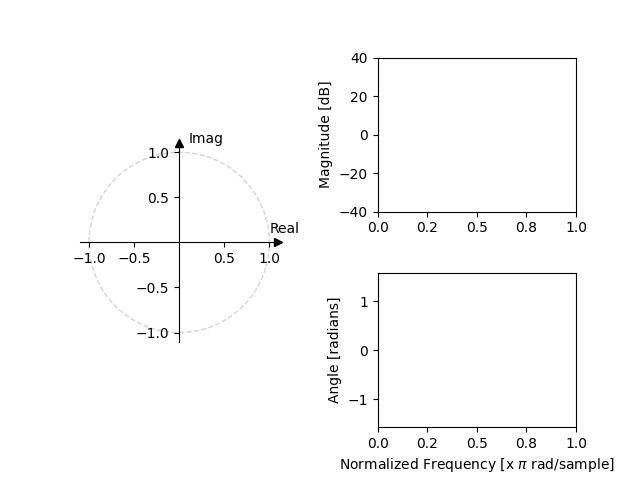

Move the slider to see how the filter changes with the pole radius and centre frequency!
Note that the omega parameter is the true value of omega in radians, but the x-axis of the Magnitude/Phase plots are normalized by $\pi$


interactive(children=(FloatSlider(value=0.8, description='rho', max=0.95, step=0.01), FloatSlider(value=0.4, d…

In [7]:
# Setting up the plots
fig, axes = plt.subplot_mosaic([["top left", "top centre"],["top left", "bottom centre"]])
plt.subplots_adjust(wspace=0.5,hspace=0.4)

# Create the unit circle
uc = patches.Circle((0,0), radius=1, fill=False, color='lightgray', ls='dashed')
axes["top left"].add_patch(uc)
 

# Plot the zeros and set marker properties    
t1, = axes["top left"].plot([], [], 'ko', ms=10)
plt.setp( t1, markersize=8.0, markeredgewidth=1.0,
          markeredgecolor='k', markerfacecolor='k')

# Plot the poles and set marker properties
t2, = axes["top left"].plot([], [], 'kx', ms=10)
plt.setp( t2, markersize=8.0, markeredgewidth=3.0,
          markeredgecolor='k', markerfacecolor='r')

axes["top left"].spines['left'].set_position('center')
axes["top left"].spines['bottom'].set_position('center')
axes["top left"].spines['right'].set_visible(False)
axes["top left"].spines['top'].set_visible(False)

axes["top left"].plot(1, 0, ">k", transform=axes["top left"].get_yaxis_transform(), clip_on=False)
axes["top left"].plot(0, 1, "^k", transform=axes["top left"].get_xaxis_transform(), clip_on=False)

# set the ticks
r = 1.1; 
axes["top left"].axis('scaled');
ticks_x = [-1, -0.5, 0.5, 1]; 
ticks_y = [-1, -0.5, 0.5, 1]; 
axes["top left"].set_xticks(ticks_x)
axes["top left"].set_yticks(ticks_y)
axes["top left"].text(1,0.1,'Real');
axes["top left"].text(0.1,1.1,'Imag');



lineMag, = axes["top centre"].plot([], [], 'k')
axes["top centre"].set_ylabel('Magnitude [dB]', color='k')
axes["top centre"].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes["top centre"].set_xlim([0, 1])
axes["top centre"].set_ylim([-40, 40])


# angles = np.unwrap(np.angle(h))
linePh, = axes["bottom centre"].plot([], [], 'k')
axes["bottom centre"].set_ylabel('Angle [radians]', color='k')
axes["bottom centre"].set_xlabel('Normalized Frequency [x $\pi$ rad/sample]')
axes["bottom centre"].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes["bottom centre"].set_ylim([-np.pi/2, np.pi/2])
axes["bottom centre"].set_xlim([0, 1])
# axes["bottom centre"].axis('tight')
plt.show()

# Create the interactive plot
def update(rho = 0.8, zeta = 0.4, omega=np.pi/4):
    
    fig.canvas.draw_idle()
    
    b1 = -2*zeta*np.cos(omega)
    b2 = zeta**2
    a1 = -2*rho*np.cos(omega)
    a2 = rho**2
    bo = 1; ao = 1;

    b =[bo,b1,b2]
    a =[ao, a1, a2]
    

    # FREQZ to get magnitude and phase
    w, h = signal.freqz(b,a)
    Mag = 20 * np.log10(abs(h))
    freq_axis = w/np.pi
    angles = np.unwrap(np.angle(h))
    
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)


    lineMag.set_data(freq_axis, Mag)
    linePh.set_data(freq_axis, angles)
    t1.set_data(z.real, z.imag)
    t2.set_data(p.real, p.imag)

print('Move the slider to see how the filter changes with the pole radius and centre frequency!')
print('Note that the omega parameter is the true value of omega in radians, but the x-axis of the Magnitude/Phase plots are normalized by $\pi$')
interact(update, rho = (0,0.95,0.01), zeta = (0,0.95,0.01), omega=(0,np.pi,np.pi/16)); 



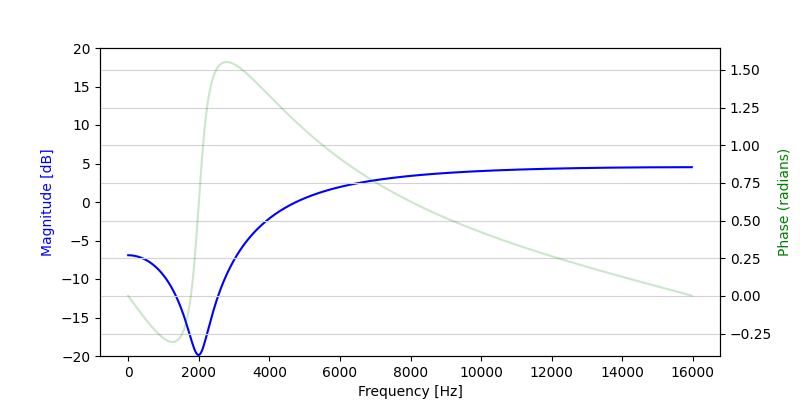

In [8]:
## Design the filter and plot the response
fs = 16000*2 # sampling freq (Hz)

# These are the filter coefficients for a biquad filter (will make a resonance or notch):
fo = 2000 # centre freq to be a notch/boost
omega = (2*np.pi*fo)/fs
# make zeta > rho for notch; rho > zeta for resonance (don't go above 1!)
zeta = 0.95
rho = 0.5

b1 = -2*zeta*np.cos(omega)
b2 = zeta**2
a1 = -2*rho*np.cos(omega)
a2 = rho**2
bo = 1; ao = 1;

b =[bo,b1,b2]
a =[ao, a1, a2]

w, h = signal.freqz(b,a)
freq_axis = w*((fs/2)/np.pi)
angles = np.unwrap(np.angle(h))

fig, ax1 = plt.subplots(figsize=(8, 4))
linelms, = ax1.plot(freq_axis, 20 * np.log10(abs(h)), 'b-')
ax1.set_ylabel('Magnitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylim([-20, 20])
# ax1.set_xlim([100, 1000])
ax2 = ax1.twinx()
linephlms, = ax2.plot(freq_axis, angles, 'g-',alpha=0.2)
ax2.set_ylabel('Phase (radians)', color='g')
ax2.grid(True,color='lightgrey')
ax2.axis('tight')
plt.show()

# print(freq_axis)

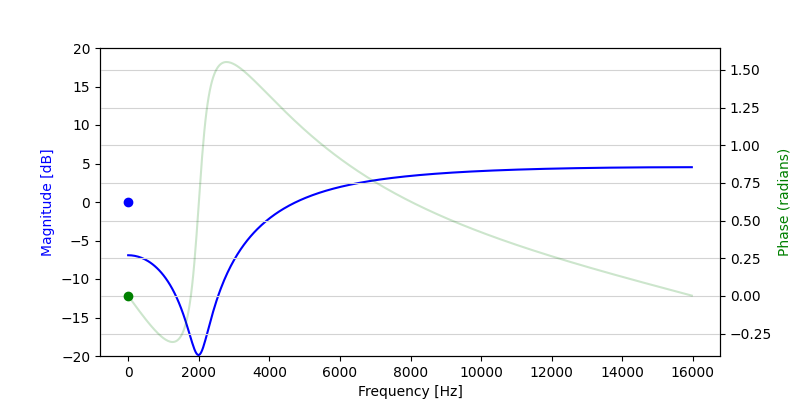

Move the slider to see how the parameters change the cosine and listen to the result


interactive(children=(IntSlider(value=500, description='f_input', max=4000, min=500), Output()), _dom_classes=…

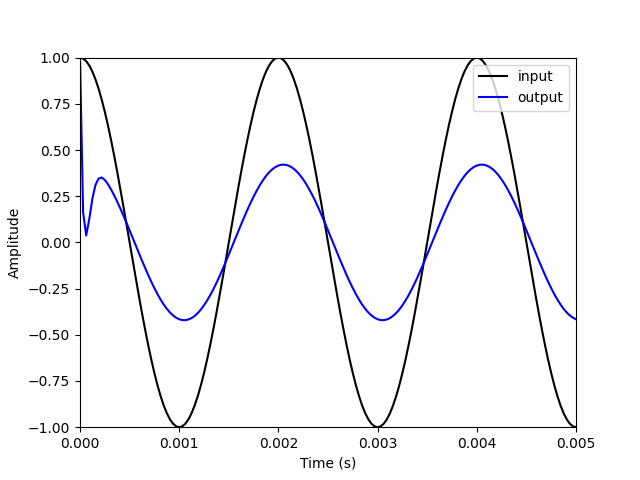

In [9]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

t = np.arange(0,2,1/fs)


fig, ax1 = plt.subplots(figsize=(8, 4))
linelms, = ax1.plot(freq_axis, 20 * np.log10(abs(h)), 'b-')
scat_pt, = ax1.plot(0, 0, 'bo')
ax1.set_ylabel('Magnitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylim([-20, 20])
# ax1.set_xlim([100, 1000])
ax2 = ax1.twinx()
linephlms, = ax2.plot(freq_axis, angles, 'g-',alpha=0.2)
scat_pt_phase, = ax2.plot(0, 0, 'go')
ax2.set_ylabel('Phase (radians)', color='g')
ax2.grid(True,color='lightgrey')
ax2.axis('tight')
plt.show()


fig, axes = plt.subplots()
line, = axes.plot([], [], 'k',label='input')
line_out, = axes.plot([], [], 'b',label='output')
axes.set_ylabel('Amplitude', color='k')
axes.set_xlabel('Time (s)', color='k')
axes.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
axes.set_xlim([0, 0.005])
axes.set_ylim([-1, 1])
axes.legend()


# Create the interactive plot
def update(f_input = 500):
    
    xn = np.cos(2*np.pi*f_input*t) # sinusoidal input
    line.set_data(t, xn)
    
    yn = signal.lfilter(b, a, xn)
    line_out.set_data(t, yn)
    
    # finding the point on filter
    [idx, val] = find_nearest(freq_axis, value=f_input)
    scat_pt.set_data([freq_axis[idx], -10], [20*np.log10(abs(h[idx])), -60])
    scat_pt_phase.set_data([freq_axis[idx], -10], [angles[idx], -60])
    
    print('INPUT:')
    IPython.display.display(Audio(xn.T, rate=fs,normalize=False))

    print('OUTPUT:')
    IPython.display.display(Audio(yn.T, rate=fs,normalize=False))

print('Move the slider to see how the parameters change the cosine and listen to the result')
interact(update, f_input=(500,4000,1)); 






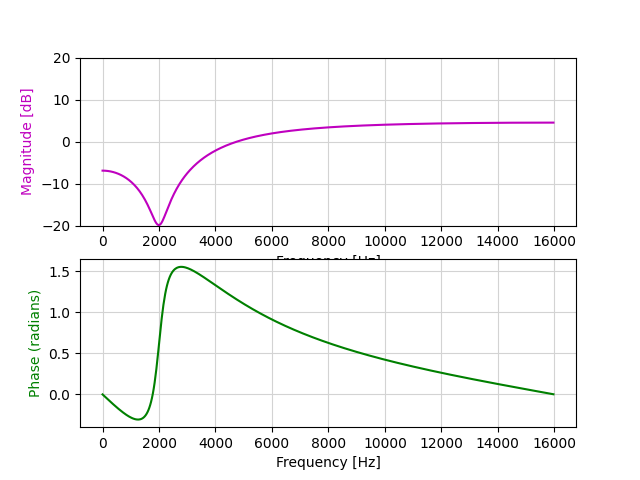

In [10]:
# These are the filter coefficients for a biquad filter (will make a resonance or notch):
fo = 2000 # centre freq to be a notch/boost
omega = (2*np.pi*fo)/fs
# make zeta > rho for notch; rho > zeta for resonance (don't go above 1!)
zeta = 0.95
rho = 0.5

b1 = -2*zeta*np.cos(omega)
b2 = zeta**2
a1 = -2*rho*np.cos(omega)
a2 = rho**2
bo = 1; ao = 1;

b =[bo,b1,b2]
a =[ao, a1, a2]

w, h = signal.freqz(b,a)
freq_axis = w*((fs/2)/np.pi)
angles = np.unwrap(np.angle(h))

fig, axes = plt.subplots(2,1)
linelms = axes[0].plot(freq_axis, 20 * np.log10(abs(h)), 'm-')
axes[0].set_ylabel('Magnitude [dB]', color='m')
axes[0].set_xlabel('Frequency [Hz]')
axes[0].grid(True,color='lightgrey')
axes[0].set_ylim([-20, 20])
# ax1.set_xlim([100, 1000])

linephlms = axes[1].plot(freq_axis, angles, 'g-')
axes[1].set_ylabel('Phase (radians)', color='g')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].grid(True,color='lightgrey')
# axes[1].axis('tight')
plt.show()
